<a href="https://colab.research.google.com/github/aubricot/computer_vision_with_eol_images/blob/master/play_for_beginners/flower_generate_tags_yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo: Using YOLOv8 to add flower tags for Angiosperm (flowering plants) images
---
*Last Updated 10 September 2025*  
-Runs in Python 3 with YOLOv8-   

Using [YOLOv8 Nano](https://yolov8.com/) trained on [Open Images V7](https://docs.ultralytics.com/datasets/detect/open-images-v7) as a method to do customized, large-scale image tagging. EOL Angiosperm images will be tagged if flowers are present using object detection. Tags will further extend EOLv3 image search functions.

Notes:   
* Run code blocks by pressing play button in brackets on left
* Change parameters using form fields on right (find details at corresponding lines of code by searching '#@param')

References:   
* Code modified from the [Ultralytics YOLOv8 tutorial](https://docs.ultralytics.com/datasets/detect/open-images-v7)
* Check out the [Ultralytics YOLO repo](https://github.com/ultralytics/ultralytics) for more documetation and tutorials

## Installs & Imports
---

In [1]:
#@title Choose where to save results
import os

# Use dropdown menu on right
save = "in Colab runtime (files deleted after each session)" #@param ["in my Google Drive", "in Colab runtime (files deleted after each session)"]

# Mount google drive to export image tagging file(s)
if 'Google Drive' in save:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

# Set up directory structure
basewd = "/content/drive/MyDrive/train"
cwd = basewd + '/' + 'yolov8'
if not os.path.exists(cwd):
    os.makedirs(cwd)
    os.chdir(cwd)
    os.makedirs('data/imgs')
    os.makedirs('data/img_info')
    os.makedirs('data/results')

%cd $cwd

/content


In [2]:
#@title Define model and functions
!uv pip install ultralytics
import ultralytics
ultralytics.checks()
import urllib.request
import cv2
import numpy as np
from ultralytics import YOLO
from matplotlib import pyplot as plt
import pandas as pd
import os

# Load the pretrained model (YOLOv8 Nano trained on Open Images V7)
model = YOLO("yolov8n-oiv7.pt")

# Load an image from URL
def load_image_from_url(url):
    try:
        resp = urllib.request.urlopen(url, timeout=10)
        img_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    except Exception as e:
        print(f"Failed to load image from {url}: {e}")
        return None

# Detect and draw flowers
def detect_and_draw_flowers(image_url):
    img = load_image_from_url(image_url)
    # Safety check
    if img is None:
        print("Image load failed for image from: ", image_url)
        return None, False
    # Run inference
    results = model(img)
    if len(results) == 0 or len(results[0].boxes) == 0:
        print("No detections for image from : ", image_url)
        return img, False

    # Comb through bounding boxes and filter for class "flower"
    detected_flower = False
    img_copy = img.copy()
    for *box, conf, cls in results[0].boxes.data:
        class_name = model.names[int(cls)]
        if "flower" in class_name.lower():
            detected_flower = True
            x1, y1, x2, y2 = map(int, box) # Get bbox coords
            # Draw bounding box
            cv2.rectangle(img_copy, (x1, y1), (x2, y2), color=(255, 0, 255), thickness=2)
            # Draw label with confidence
            label = f"{class_name} {conf:.2f}"
            (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
            cv2.rectangle(img_copy, (x1, y1 - 20), (x1 + w, y1), (255, 0, 255), -1)  # filled rectangle for text bg
            cv2.putText(img_copy, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

    if not detected_flower:
        print("No flowers detected in image from : ", image_url)

    return img_copy, detected_flower

Ultralytics 8.3.198 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.0/225.8 GB disk)


## Run inference - Detect flowers in images
---


0: 448x640 1 Flower, 298.5ms
Speed: 2.3ms preprocess, 298.5ms inference, 5.3ms postprocess per image at shape (1, 3, 448, 640)


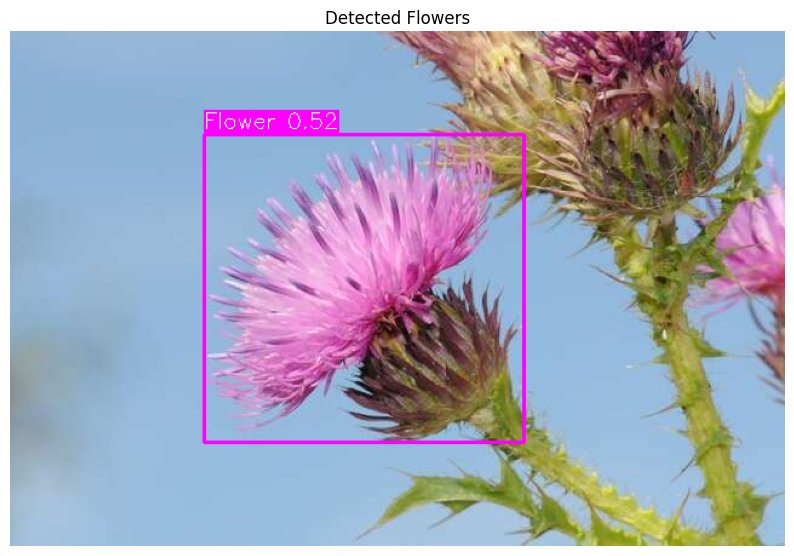

Image with bounding boxes saved to to: /data/results/913.63779_w_bboxes.jpg


In [6]:
#@title Find flowers in images from URL

# TO DO: Choose a URL from the dropdown menu to the right or enter your own URL
image_url = "https://content.eol.org/data/media/a1/7c/66/913.63779.jpg" # @param ["https://content.eol.org/data/media/63/8d/cf/18.51222129f0d46f4ff5b31704904752f0.jpg","https://content.eol.org/data/media/9d/d8/64/851.126960-5_jpg.580x360.jpg","https://content.eol.org/data/media/a1/83/1d/913.67951.jpg","https://content.eol.org/data/media/a1/7c/66/913.63779.jpg","https://content.eol.org/data/media/a1/9f/76/913.8115.580x360.jpg"] {"allow-input":true}
img_with_boxes, flower_found = detect_and_draw_flowers(image_url)

# Plot detections on image
plt.figure(figsize=(10, 10))
plt.imshow(img_with_boxes)
plt.axis('off')
plt.title("Detected Flowers")
plt.show()

# Convert back to BGR for saving with OpenCV
img_bgr = cv2.cvtColor(img_with_boxes, cv2.COLOR_RGB2BGR)

# Define filename
fname = os.path.splitext(image_url.split("/")[-1].split("?")[0])[0]  # Get name from URL
fname = fname + "_w_bboxes.jpg"

# Save image
outfpath = os.path.join('/data/results', fname)
cv2.imwrite(outfpath, img_bgr)
print(f"Image with bounding boxes saved to to: {outfpath}")

## Export detections to .tsv file for tagging
---

In [4]:
#@title Define functions

# List to store detection results
prediction_records = []

# Detect flowers and record details
def detect_flowers_and_record(image_url):
    img = load_image_from_url(image_url)
    if img is None:
        print(f"Failed to load image: {image_url}")
        return
    # Run inference
    results = model(img)
    detections = results[0].boxes.data
    if len(detections) == 0:
        prediction_records.append([image_url, False, '', '', '', '', ''])
        return
    # Loop through bounding boxes and find matches for "flower"
    flower_detected = False
    for *box, conf, cls in detections:
        class_name = model.names[int(cls)]
        if "flower" in class_name.lower():
            flower_detected = True
            x1, y1, x2, y2 = map(int, box)
            width = x2 - x1
            height = y2 - y1
            # Record results to save to tsv
            prediction_records.append([
                image_url, "flower", x1, y1, width, height, round(float(conf), 4)
            ])
    # Fill row with blanks if nothing detected
    if not flower_detected:
        prediction_records.append([image_url, False, '', '', '', '', ''])

In [5]:
#@title Run inference on multiple URLs and save results to tsv

# Define URLs for inference
urls = ["https://content.eol.org/data/media/63/8d/cf/18.51222129f0d46f4ff5b31704904752f0.jpg",
      "https://content.eol.org/data/media/9d/d8/64/851.126960-5_jpg.580x360.jpg",
      "https://content.eol.org/data/media/a1/83/1d/913.67951.jpg",
      "https://content.eol.org/data/media/a1/7c/66/913.63779.jpg",
      "https://content.eol.org/data/media/a1/9f/76/913.8115.580x360.jpg"] # TO DO: Use your own URL's for inference

# Loop through URLs and run inference
for url in urls:
    detect_flowers_and_record(url)

# Save rseults/bounding boxes to file
df_preds = pd.DataFrame(prediction_records, columns=["url", "tag", "xmin", "ymin", "bbox_w", "bbox_h", "confidence"])
outfpath = os.path.join('data/results/' 'angiosperm_flower_tag_predictions.tsv')
df_preds.to_csv(outfpath, sep='\t', index=False)
print(f"Predictions saved to: {outfpath}")


0: 480x640 6 Flowers, 406.6ms
Speed: 21.1ms preprocess, 406.6ms inference, 34.3ms postprocess per image at shape (1, 3, 480, 640)

0: 576x640 (no detections), 276.1ms
Speed: 4.1ms preprocess, 276.1ms inference, 4.1ms postprocess per image at shape (1, 3, 576, 640)

0: 448x640 2 Flowers, 1 Plant, 214.2ms
Speed: 2.2ms preprocess, 214.2ms inference, 4.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 Flower, 203.8ms
Speed: 2.4ms preprocess, 203.8ms inference, 3.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 Plant, 222.3ms
Speed: 4.0ms preprocess, 222.3ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 480)
Predictions saved to: data/results/angiosperm_flower_tag_predictions.tsv
